In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate
from scipy.integrate import odeint
import time
from IPython import display
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import os
plt.rcParams['axes.titlesize'] = 22
plt.rcParams['axes.labelsize'] = 20  
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
plt.rcParams['axes.titlepad'] = 40 
plt.rcParams['axes.labelpad'] = 16 

In [2]:
#Constants:
T = 273
P = 1 #bar
H2O = 1.0

#Minerals:
FeS = 1.0
FeOOH = 1.0 #since it's a mineral
ker415 = 1.0
ker = 1.0

#pH-dependent concentrations:
pH = np.array([9.0, 11.0])
H = 10**(-pH)

#Reductants
H2 = np.array([1e-4, 2e-7])
CH4 = np.array([3e-5, 4e-8])

#Oxidants
CO2 = np.array([7e-5, 1e-7])

#kerogen:
ker = 3e-4

In [3]:
#Reactions - let's split these up between methanogenesis, aerobic, & anaerobic reactions
#K values calculated for T = 0.0C and P = 74bar (from Chris's book chapter)

##Methanogenesis##
# this will just have 2 values - for pH 9 and pH 11
r1 = '4H2 + CO2 = CH4 + 2H2O                  '
K1 = 37.512 #at 0 deg C, 75 bar, from Chris's book chapter
Q1 = np.log10(CH4) + 2*np.log10(H2O) - np.log10(CO2) - 4*np.log10(H2)

##Aerobic reactions##

#2 methane oxidation
r2 = ('0.5CH4 + O2 = 0.5CO2 + H2O', '0.25CH4 + H2O2 = 0.25CO2 + 6/4H2O')
K2 = np.array([82.253,59.397])

#3 sulfide oxidation
r3 = ('0.5HS + O2 = 0.5SO4 + 0.5H', '0.25HS + H2O2 = 0.25SO4 + 0.25H + H2O')                       
K3 = np.array([76.095,56.318])

#4 iron sulfide oxidation
r4 = ('(16/31)Fe0.875S + O2 + (2/31)H2O = (14/31)Fe(II) + (16/31)SO4 + (4/31)H+', 
      '(8/31)Fe0.875S + H2O2 = (7/31)Fe(II) + (8/31)SO4 + (2/31)H + (30/31)H2O')
K4 = np.array([73.151, 54.847])

#5 hydrogen oxidation
r5 = ('2H2 + O2 = 2H2O', 'H2 + H2O2 = 2H2O')                         
K5 = np.array([101.009, 68.7754])

##Anaerobic Reactions##

#6 sulfate reduction
r6 = '4H2 + SO4 + H+ = HS + 4H2O              '
K6 = 49.827

#7 anaerobic oxidation of methane
r7 = 'CH4 + SO4 + H = CO2 + HS + 2H2O         '
K7 = 12.317

#8 Reduction of ferric iron
r8 = '0.5H2 + FeOOH + 2H+ = 2H2O + Fe(II)       '
K8 = 16.514

#9 Aerobic Kerogen Oxidation:
#415:
r9 = ('(2/1157)C415H698O22 + O2 = (830/1157)CO2 + (698/1157)H2O', 
      '(1/1157)C415H698O22 + H2O2 = (415/1157)CO2 + (1506/1157)H2O')
K9 = np.array([76.0367,  43.803])

# 2/1057 C406H528O19 + O2 = 528/1057 H2O + 812/1057 CO2 - type b
# 1/1057 C406H528O19 + H2O2 = 406/1057 CO2 + 1321/1057 H2O
K9a = np.array([83.11571, 59.82862])

# 1/628 C515H596O72 + O2 = 298/628 H2O + 515/628 CO2 - type c
# 1/1256 C515H596O72 + H2O2 = 515/1256 CO2 + 1554/1256 H2O
K9b =  np.array([83.59108, 60.0663])

#415:
r10a = '(4/1157)C415H698O22 + SO4 + H+ = (1660/1157)CO2 + HS- + (1396/1157)H2O'
K10a = 14.948

#4/1057 C406H528O19 + SO4{2-} + H{+} = 1056/1057 H2O + 1624/1057 CO2 + HS{-}
K10a1 = 14.04259

# 1/314 C515H596O72 + SO4{2-} + H{+} = 298/314 H2O + 515/314 CO2 + HS{-}
K10a2 = 14.99333

#415:
r10b = '(1/2314)C415H698O22 + FeOOH + 2H+ = (415/2314)CO2 + Fe{2+} + (1910/1157)H2O'
K10b1 = 12.155

# 1/2114 C406H528O19 + FeOOH + 2 H{+} = 3435/2114 H2O + 406/2114 CO2 + Fe{2+}
K10b2 = 12.04092

# 1/2512 C515H596O72 + FeOOH + 2 H{+} = 4066/2512 H2O + 515/2512 CO2 + Fe{2+
K10b3 = 12.15976

# rxns = np.array([r1, r2, r3, r4, r5, r6, r7, r8])
# K = np.array([K1, K2, K3, K4, K5, K6, K7, K8])


In [4]:
#Affinity:
def A(T, K, Q):
	R = 8.31446 #J mol^-1 K^-1
	A = (2.3026 * R * T * (K - Q))/1000.0
	return A


#Power:
H2_mix = np.array([0.004, 0.014])
plume_v = 200.0 #kg/s

#convert mixing ratios to annual production rates
def mix_to_rate(mix, v):
    return v*(1000.0/18.015)*(3600*24*365)*mix

r_H2 = mix_to_rate(H2_mix, plume_v)
r_ker = mix_to_rate(ker, plume_v)
print(r_ker)

#calculate power
def power(aff, rate):
    return (aff*1000.0)*(rate/(3600*24*365)) #(J/mol)*(mol/s) = J/s = W

#For printing in the tables
def error(a):
    mid = np.median(a)
    err = np.max(a)-mid
    return mid,err

105032472.9392173


In [5]:
#methanogenesis:
meth_aff = A(T,K1,Q1) 
print('Methanogenesis Affinity: %3d, %3d' %error(meth_aff))

P_meth_1 = power(meth_aff,r_H2[0]) 
P_meth_2 = power(meth_aff,r_H2[1]) 

P_meth = np.append(P_meth_1, P_meth_2)
#print('Methanogenesis Power: %3d, %3d' %error(P_meth/1e3))
print(P_meth/1e3)

Methanogenesis Affinity:  86,  28
[ 5078.29321664  2579.5482334  17774.02625824  9028.41881689]


In [6]:
meth_aff

array([114.35681537,  58.08820178])

In [7]:
###Case I (No reductants)###

#Two total possibilities: O2 or H2O2

#Old Enceladus:
fname = open('Oxidants.txt')

#Young Enceladus:
#fname = open('YoungEnceladus_Oxidants.txt')


for i, lines in enumerate(fname):
    if i == 2: 
        case_I = lines.split()
        O2_I = float(case_I[1]) #concentration for both pH 9 & 11
        rO2 = float(case_I[2]) #since the production rate of O2/H2O2 is always the same
    if i == 3: 
        case_II = lines.split()
        H2O2_I = float(case_II[1]) 
        rH2O2 = float(case_II[2])
fname.close()

#Picking low concentrations for reductants, informed somewhat by time constants
# HS_I = 1e-18
# Fe_I = 1e-20
#Most updated version: no reactions w/ reductants!

#Reaction Quotients:
#Oxygen Reactions:

#methane oxidation: '0.5CH4 + O2 = 0.5CO2 + H2O', 
                    #     '0.25CH4 + H2O2 = 0.25CO2 + 6/4H2O'
Q2 = np.array([(0.5*np.log10(CO2[0]) + np.log10(H2O) - 0.5*np.log10(CH4[0]) - np.log10(O2_I)), 
               (0.5*np.log10(CO2[1]) + np.log10(H2O) - 0.5*np.log10(CH4[1]) - np.log10(O2_I)),
               (0.25*np.log10(CO2[0]) + (6/4)*np.log10(H2O) - 0.25*np.log10(CH4[0]) - np.log10(H2O2_I)),
               (0.25*np.log10(CO2[1]) + (6/4)*np.log10(H2O) - 0.25*np.log10(CH4[1]) - np.log10(H2O2_I))])
aff_2I = np.zeros(4)
P_2I = np.zeros(4)
for i in range(0,4):
    if i in (0,1):
        aff_2I[i] = A(T,K2[0],Q2[i])
        P_2I[i] = power(aff_2I[i], rO2)
    else:
        aff_2I[i] = A(T,K2[1],Q2[i])
        P_2I[i] = power(aff_2I[i], rH2O2)

 
#3 sulfide oxidation: '0.5HS + O2 = 0.5SO4 + 0.5H', 
#                     '0.25*HS + H2O2 = 0.25*SO4 + 0.25*H + H2O')                      '
# Q3 = np.array([(0.5*np.log10(H[0]) + 0.5*np.log10(SO4_I[0]) - np.log10(O2_I) - 0.5*np.log10(HS_I)),
#               (0.5*np.log10(H[1]) + 0.5*np.log10(SO4_I[1]) - np.log10(O2_I) - 0.5*np.log10(HS_I)),
#               (0.25*np.log10(H[0]) + 0.25*np.log10(SO4_I[0]) + np.log10(H2O) - np.log10(H2O2_I) - 0.25*np.log10(HS_I)),
#               (0.25*np.log10(H[1]) + 0.25*np.log10(SO4_I[1]) + np.log10(H2O) - np.log10(H2O2_I) - 0.25*np.log10(HS_I))])
# aff_3I = np.zeros(4)
# P_3I = np.zeros(4)
# for i in range(0,4):
#     if i in (0,1):
#         aff_3I[i] = A(T,K3[0],Q3[i])
#         P_3I[i] = power(aff_3I[i], rO2)
#     else:
#         aff_3I[i] = A(T,K3[1],Q3[i])
#         P_3I[i] = power(aff_3I[i], rH2O2)


#4 iron sulfide oxidation:
# Q4 = np.array([((2/7)*np.log10(Fe_I) + (4/7)*np.log10(SO4_I[0]) + (4/7)*np.log10(H[0]) - (2/7)*np.log10(H2O) - np.log10(O2_I) - (2/7)*np.log10(FeS2)),
#               ((2/7)*np.log10(Fe_I) + (4/7)*np.log10(SO4_I[1]) + (4/7)*np.log10(H[1]) - (2/7)*np.log10(H2O) - np.log10(O2_I) - (2/7)*np.log10(FeS2)),
#               ((1/7)*np.log10(Fe_I) + (2/7)*np.log10(SO4_I[0]) + (2/7)*np.log10(H[0]) + (6/7)*np.log10(H2O) - np.log10(H2O2_I) - (1/7)*np.log10(FeS2)),
#               ((1/7)*np.log10(Fe_I) + (2/7)*np.log10(SO4_I[1]) + (2/7)*np.log10(H[1]) + (6/7)*np.log10(H2O) - np.log10(H2O2_I) - (1/7)*np.log10(FeS2))])
# aff_4I = np.zeros(4)
# P_4I = np.zeros(4)
# for i in range(0,4):
#     if i in (0,1):
#         aff_4I[i] = A(T,K4[0],Q4[i])
#         P_4I[i] = power(aff_4I[i], rO2)
#     else:
#         aff_4I[i] = A(T,K4[1],Q4[i])
#         P_4I[i] = power(aff_4I[i], rH2O2)

#5 hydrogen oxidation: 2H2 + O2 = 2H2O   
#                     'H2 + H2O2 = 2H2O''
Q5 = np.array([(2*np.log10(H2O) - 2*np.log10(H2[0]) - np.log10(O2_I)),
               (2*np.log10(H2O) - 2*np.log10(H2[1]) - np.log10(O2_I)),
               (2*np.log10(H2O) - np.log10(H2[0]) - np.log10(H2O2_I)),
               (2*np.log10(H2O) - np.log10(H2[1]) - np.log10(H2O2_I))])
aff_5I = np.zeros(4)
P_5I = np.zeros(4)
for i in range(0,4):
    if i in (0,1):
        aff_5I[i] = A(T,K5[0],Q5[i])
        P_5I[i] = power(aff_5I[i], rO2)
    else:
        aff_5I[i] = A(T,K5[1],Q5[i])
        P_5I[i] = power(aff_5I[i], rH2O2)

#5 aerobic kerogen 415 oxidation : ('(1/404)C415H698O22 + O2 = (415/404)CO2 + (349/404)H2', 
#      '(1/404)C415H698O22 + H2O2 = (415/404)CO2 + (753/404)H2')                     '
Q9 = np.array([((830/1157)*np.log10(CO2[0]) + (698/1157)*np.log10(H2O) - (2/1157)*np.log10(ker415) - np.log10(O2_I)),
               ((830/1157)*np.log10(CO2[1]) + (698/1157)*np.log10(H2O) - (2/1157)*np.log10(ker415) - np.log10(O2_I)),
               ((415/1157)*np.log10(CO2[0]) + (1506/1157)*np.log10(H2O) - (1/1157)*np.log10(ker415) - np.log10(H2O2_I)),
               ((415/1157)*np.log10(CO2[1]) + (1506/1157)*np.log10(H2O) - (1/1157)*np.log10(ker415) - np.log10(H2O2_I))])
aff_9I = np.zeros(4)
P_9I = np.zeros(4)
for i in range(0,4):
    if i in (0,1):
        aff_9I[i] = A(T,K9[0],Q9[i])
        P_9I[i] = power(aff_9I[i], rO2)
    else:
        aff_9I[i] = A(T,K9[1],Q9[i])
        P_9I[i] = power(aff_9I[i], rH2O2)
    
#5 aerobic kerogen 406 oxidation : 
# 2/1057 C406H528O19 + O2 = 528/1057 H2O + 812/1057 CO2 - type b
# 1/1057 C406H528O19 + H2O2 = 406/1057 CO2 + 1321/1057 H2O                     '
Q9a = np.array([((812/1057)*np.log10(CO2[0]) + (528/1057)*np.log10(H2O) - (2/1057)*np.log10(ker) - np.log10(O2_I)),
               ((812/1057)*np.log10(CO2[1]) + (528/1057)*np.log10(H2O) - (2/1057)*np.log10(ker) - np.log10(O2_I)),
               ((406/1057)*np.log10(CO2[0]) + (1321/1057)*np.log10(H2O) - (1/1057)*np.log10(ker) - np.log10(H2O2_I)),
               ((406/1057)*np.log10(CO2[1]) + (1321/1057)*np.log10(H2O) - (1/1057)*np.log10(ker) - np.log10(H2O2_I))])
aff_9aI = np.zeros(4)
P_9aI = np.zeros(4)
for i in range(0,4):
    if i in (0,1):
        aff_9aI[i] = A(T,K9a[0],Q9a[i])
        P_9aI[i] = power(aff_9aI[i], rO2)
    else:
        aff_9aI[i] = A(T,K9a[1],Q9a[i])
        P_9aI[i] = power(aff_9aI[i], rH2O2)
    
#5 aerobic kerogen 515 oxidation : 
# 1/628 C515H596O72 + O2 = 298/628 H2O + 515/628 CO2 - type c
# 1/1256 C515H596O72 + H2O2 = 515/1256 CO2 + 1554/1256 H2O
Q9b = np.array([((515/628)*np.log10(CO2[0]) + (298/628)*np.log10(H2O) - (1/628)*np.log10(ker) - np.log10(O2_I)),
               ((515/628)*np.log10(CO2[1]) + (298/628)*np.log10(H2O) - (1/628)*np.log10(ker) - np.log10(O2_I)),
               ((515/1256)*np.log10(CO2[0]) + (1554/1256)*np.log10(H2O) - (1/1256)*np.log10(ker) - np.log10(H2O2_I)),
               ((515/1256)*np.log10(CO2[1]) + (1554/1256)*np.log10(H2O) - (1/1256)*np.log10(ker) - np.log10(H2O2_I))])
aff_9bI = np.zeros(4)
P_9bI = np.zeros(4)
for i in range(0,4):
    if i in (0,1):
        aff_9bI[i] = A(T,K9b[0],Q9b[i])
        P_9bI[i] = power(aff_9bI[i], rO2)
    else:
        aff_9bI[i] = A(T,K9b[1],Q9b[i])
        P_9bI[i] = power(aff_9bI[i], rH2O2)
        
print("Case I: Oxidant buildup - low concentrations of sulfur/iron")
print(" ")
print("Affinities:")
print(" ")
print("1. methane oxidation with O2, pH = 9 & 11: %2.0f, %2.0f" %error(aff_2I[0:2]))
print("   methane oxidation with H2O2, pH = 9 & 11: %.1f, %.1f" %error(aff_2I[2:]))
# print("2. sulfide oxidation with O2, pH = 9 & 11: %.1f, %.1f" %error(aff_3I[0:2]))
# print("   sulfide oxidation with H2O2, pH = 9 & 11: %.1f, %.1f" %error(aff_3I[2:]))
# print("3. iron sulfide oxidation with O2, pH = 9 & 11: %.1f, %.1f" %error(aff_4I[0:2]))
# print("   iron sulfide oxidation with H2O2, pH = 9 & 11: %.1f, %.1f" %error(aff_4I[2:]))
print("4. hydrogen oxidation, pH = 9 & 11: %.1f, %.1f" %error(aff_5I[0:2]))
print("   hydrogen oxidation, pH = 9 & 11: %.1f, %.1f" %error(aff_5I[2:]))
print("4. kerogen oxidation with O2, pH = 9 & 11: %.1f, %.1f" %error(np.append(np.append(aff_9I[0:2], aff_9aI[0:2]), aff_9bI[0:2])))
print("   kerogen 415 oxidation with H2O2, pH = 9 & 11: %.1f, %.1f" %error(np.append(np.append(aff_9I[2:],aff_9aI[2:]),aff_9bI[2:])))

print(" ")
print("Power:")
print(" ")
print("1. methane oxidation, pH = 9 & 11: %3d, %3d" %error(P_2I[0:2]/1e3))
print("   methane oxidation, pH = 9 & 11: %3d, %3d" %error(P_2I[2:]/1e3))
# print("2. sulfide oxidation, pH = 9 & 11: %.1e, %.1e" %error(P_3I[0:2]/1e5))
# print("   sulfide oxidation, pH = 9 & 11: %.1e, %.1e" %error(P_3I[2:]/1e5))
# print("3. iron sulfide oxidation, pH = 9 & 11: %.1e, %.1e" %error(P_4I[0:2]/1e5))
# print("   iron sulfide oxidation, pH = 9 & 11: %.1e, %.1e" %error(P_4I[2:]/1e5))
print("4. hydrogen oxidation, pH = 9 & 11: %3d, %3d"%error(P_5I[0:2]/1e3))
print("   hydrogen oxidation, pH = 9 & 11: %3d, %3d" %error(P_5I[2:]/1e3))
print("4. kerogen oxidation, pH = 9 & 11: %3d, %3d" %error(np.append(np.append(P_9I[0:2]/1e3,P_9aI[0:2]/1e3),P_9bI[0:2]/1e3)))
print("   kerogen oxidation, pH = 9 & 11: %3d, %3d" %error(np.append(np.append((P_9I[2:]/1e3),P_9aI[2:]/1e3), P_9bI[2:]/1e3)))


#Combined Powers for all Case I aerobes:
P_I = np.append(P_2I, np.append(P_5I, P_9I))

Case I: Oxidant buildup - low concentrations of sulfur/iron
 
Affinities:
 
1. methane oxidation with O2, pH = 9 & 11: 415,  0
   methane oxidation with H2O2, pH = 9 & 11: 296.9, 0.0
4. hydrogen oxidation, pH = 9 & 11: 458.4, 14.1
   hydrogen oxidation, pH = 9 & 11: 318.4, 7.1
4. kerogen oxidation with O2, pH = 9 & 11: 439.3, 14.0
   kerogen 415 oxidation with H2O2, pH = 9 & 11: 308.8, 7.0
 
Power:
 
1. methane oxidation, pH = 9 & 11: 107,   0
   methane oxidation, pH = 9 & 11: 112,   0
4. hydrogen oxidation, pH = 9 & 11: 118,   3
   hydrogen oxidation, pH = 9 & 11: 120,   2
4. kerogen oxidation, pH = 9 & 11: 113,   3
   kerogen oxidation, pH = 9 & 11: 117,   2


In [8]:
print(aff_9bI)
print(P_9bI)
print((aff_9bI[0:2]*1000.0)*(rO2/(3600*24*365)))
print((aff_9bI[2:]*1000.0)*(rH2O2/(3600*24*365)))

[441.09044905 453.28483728 309.74551362 315.84270773]
[114040.67945436 117193.44851176 117441.24512725 119753.02055954]
[114040.67945436 117193.44851176]
[117441.24512725 119753.02055954]


In [9]:
### Case II ###

#2) 4 different O2 aqueous concentrations (pH 9, aSiO2 = -8,-3, pH11, aSiO2 = -8, -3)
#3) 4 different H2O2 aqueous concentrations

#Old values with troilite:
#HS = np.array([3.09e-6, 3.535e-5, 3.082e-6, 1.753e-4,3.09e-6, 3.535e-5, 3.082e-6, 1.753e-4])
#Fe2 = np.array([1.415e-6, 2.912e-8, 1.374e-9, 1.323e-12, 1.415e-6, 2.912e-8, 1.374e-9, 1.323e-12])

HS = np.array([4.96e-05, 4.96e-05, 2.66e-06, 2.66e-06, 4.96e-05, 4.96e-05, 2.66e-06, 2.66e-06])
Fe2 = np.array([2.61E-07, 4.28E-09, 8.02E-10, 9.83E-13, 2.61E-07, 4.28E-09, 8.02E-10, 9.83E-13]) 

O2_aq = np.zeros(4)
H2O2_aq = np.zeros(4)

SO4_aq = np.zeros(8)
rSO4_aq = np.zeros(8)
rFeOOH_aq = np.zeros(8) #only rate - activity is 1

#Old Enceladus:
fname = open('Oxidants.txt')

#Young Enceladus:
#fname = open('YoungEnceladus_Oxidants.txt')

for i, lines in enumerate(fname):
    #Aqueous O2, pH = 9
    if i == 7:
        aqO2_case9 = lines.split()
        O2_aq[0] = aqO2_case9[1] #aSiO2 = -8
        O2_aq[1] = aqO2_case9[3] #aSiO2 = -3
    if i == 8:
        aqSO4_case9 = lines.split()
        SO4_aq[0] = aqSO4_case9[1] #aSiO2 = -8
        rSO4_aq[0] = aqSO4_case9[2] #aSiO2 = -8
        SO4_aq[1] = aqSO4_case9[3] #aSiO2 = -3
        rSO4_aq[1] = aqSO4_case9[4] #aSiO2 = -3
    if i == 9:
        aqFeOOH_case9 = lines.split()
        rFeOOH_aq[0] = aqFeOOH_case9[2]
        rFeOOH_aq[1] = aqFeOOH_case9[4]
    #Aqueous O2, pH = 11
    if i == 12:
        aqO2_case11 = lines.split()
        O2_aq[2] = aqO2_case11[1] #aSiO2 = -8
        O2_aq[3] = aqO2_case11[3] #aSiO2 = -3
    if i == 13:
        aqSO4_case11 = lines.split()
        SO4_aq[2] = aqSO4_case11[1] #aSiO2 = -8
        rSO4_aq[2] = aqSO4_case11[2] #aSiO2 = -8
        SO4_aq[3] = aqSO4_case11[3] #aSiO2 = -3
        rSO4_aq[3] = aqSO4_case11[4] #aSiO2 = -3
    if i == 14:
        aqFeOOH_case11 = lines.split()
        rFeOOH_aq[2] = aqFeOOH_case11[2]
        rFeOOH_aq[3] = aqFeOOH_case11[4]
    #Aqueous H2O2, pH = 9
    if i == 17:
        aqH2O2_case9 = lines.split()
        H2O2_aq[0] = aqH2O2_case9[1] #aSiO2 = -8
        H2O2_aq[1] = aqH2O2_case9[3] #aSiO2 = -3
    if i == 18:
        aqSO4_case9 = lines.split()
        SO4_aq[4] = aqSO4_case9[1] #aSiO2 = -8
        rSO4_aq[4] = aqSO4_case9[2] #aSiO2 = -8
        SO4_aq[5] = aqSO4_case9[3] #aSiO2 = -3
        rSO4_aq[5] = aqSO4_case9[4] #aSiO2 = -3
    if i == 19:
        aqFeOOH_case9 = lines.split()
        rFeOOH_aq[4] = aqFeOOH_case9[2]
        rFeOOH_aq[5] = aqFeOOH_case9[4]
    #Aqueous H2O2, pH = 11
    if i == 22:
        aqH2O2_case11 = lines.split()
        H2O2_aq[2] = aqH2O2_case11[1] #aSiO2 = -8
        H2O2_aq[3] = aqH2O2_case11[3] #aSiO2 = -3
    if i == 23:
        aqSO4_case11 = lines.split()
        SO4_aq[6] = aqSO4_case11[1] #aSiO2 = -8
        rSO4_aq[6] = aqSO4_case11[2] #aSiO2 = -8
        SO4_aq[7] = aqSO4_case11[3] #aSiO2 = -3
        rSO4_aq[7] = aqSO4_case11[4] #aSiO2 = -3
    if i == 24:
        aqFeOOH_case11 = lines.split()
        rFeOOH_aq[6] = aqFeOOH_case11[2]
        rFeOOH_aq[7] = aqFeOOH_case11[4]
fname.close()

In [10]:
#Reaction Quotients:
#Oxygen Reactions:

#2 methane oxidation: CH4 + 2O2 = CO2 + 2H2O 
aff_2II = np.zeros(8)
P_2II = np.zeros(8)
Q2 = np.zeros(8)
for i in range(0,4):
    if i in (0,1):
        Q2[i] = 0.5*np.log10(CO2[0]) + np.log10(H2O) - 0.5*np.log10(CH4[0]) - np.log10(O2_aq[i])
        Q2[i+4] = 0.25*np.log10(CO2[0]) + (6/4)*np.log10(H2O) - 0.25*np.log10(CH4[0]) - np.log10(H2O2_aq[i])
    else:
        Q2[i] = 0.5*np.log10(CO2[1]) + np.log10(H2O) - 0.5*np.log10(CH4[1]) - np.log10(O2_aq[i])
        Q2[i+4] = 0.25*np.log10(CO2[1]) + (6/4)*np.log10(H2[1]) - 0.25*np.log10(CH4[1]) - np.log10(H2O2_aq[i])
aff_2II[0:4] = A(T,K2[0],Q2[0:4])
aff_2II[4:] = A(T,K2[1],Q2[4:])
P_2II[0:4] = power(aff_2II[0:4], rO2)
P_2II[4:] = power(aff_2II[4:], rH2O2)

#3 sulfide oxidation:
aff_3II = np.zeros(8)
P_3II = np.zeros(8)
Q3 = np.zeros(8)
for i in range(0,4):
    if i in (0,1):
        Q3[i] = 0.5*np.log10(H[0]) + 0.5*np.log10(SO4_aq[i]) - np.log10(O2_aq[i]) - 0.5*np.log10(HS[i])
        Q3[i+4] = 0.25*np.log10(H[0]) + 0.25*np.log10(SO4_aq[i]) + np.log10(H2O) - np.log10(H2O2_aq[i]) - 0.25*np.log10(HS[i])
    else:
        Q3[i] = 0.5*np.log10(H[1]) + 0.5*np.log10(SO4_aq[i]) - np.log10(O2_aq[i]) - 0.5*np.log10(HS[i])
        Q3[i+4] = 0.25*np.log10(H[1]) + 0.25*np.log10(SO4_aq[i]) + np.log10(H2O) - np.log10(H2O2_aq[i]) - 0.25*np.log10(HS[i])
aff_3II[0:4] = A(T,K3[0],Q3[0:4])
aff_3II[4:] = A(T,K3[1],Q3[4:])
P_3II[0:4] = power(aff_3II[0:4], rO2)
P_3II[4:] = power(aff_3II[4:], rH2O2)

#4 iron sulfide oxidation:
aff_4II = np.zeros(8)
P_4II = np.zeros(8)
Q4 = np.zeros(8)
for i in range(0,4):
    if i in (0,1):    
        Q4[i] = (16/31)*np.log10(SO4_aq[i]) + (14/31)*np.log10(Fe2[i]) + (4/31)*np.log10(H[0]) - (2/31)*np.log10(H2O) - np.log10(O2_aq[i]) - (16/31)*np.log10(FeS)
        Q4[i+4] = (8/31)*np.log10(SO4_aq[i]) + (7/31)*np.log10(Fe2[i]) + (2/31)*np.log10(H[0]) + (30/31)*np.log10(H2O) - np.log10(H2O2_aq[i]) - (8/31)*np.log10(FeS)
    else:
        Q4[i] = (16/31)*np.log10(SO4_aq[i]) + (14/31)*np.log10(Fe2[i]) + (4/31)*np.log10(H[1]) - (2/31)*np.log10(H2O) - np.log10(O2_aq[i]) - (16/31)*np.log10(FeS)
        Q4[i+4] = (8/31)*np.log10(SO4_aq[i]) + (7/31)*np.log10(Fe2[i]) + (2/31)*np.log10(H[1]) + (30/31)*np.log10(H2O) - np.log10(H2O2_aq[i]) - (8/31)*np.log10(FeS)
aff_4II[0:4] = A(T,K4[0],Q4[0:4])
aff_4II[4:] = A(T,K4[1],Q4[4:])
P_4II[0:4] = power(aff_4II[0:4], rO2)
P_4II[4:] = power(aff_4II[4:], rH2O2)

#5 hydrogen oxidation: 2H2 + O2 = 2H2O
aff_5II = np.zeros(8)
P_5II = np.zeros(8)
Q5 = np.zeros(8)
for i in range(0,4):
    if i in (0,1):
        Q5[i] = 2*np.log10(H2O) - 2*np.log10(H2[0]) - np.log10(O2_aq[i])
        Q5[i+4] = 2*np.log10(H2O) - 1*np.log10(H2[0]) - np.log10(H2O2_aq[i])
    else:
        Q5[i] = 2*np.log10(H2O) - 2*np.log10(H2[1]) - np.log10(O2_aq[i])
        Q5[i+4] = 2*np.log10(H2O) - 1*np.log10(H2[1]) - np.log10(H2O2_aq[i])
aff_5II[0:4] = A(T,K5[0],Q5[0:4])
aff_5II[4:] = A(T,K5[1],Q5[4:])
P_5II[0:4] = power(aff_5II[0:4], rO2)
P_5II[4:] = power(aff_5II[4:], rH2O2)


#5 aerobic kerogen 415 oxidation  
# aff_9II = np.zeros(8)
# P_9II = np.zeros(8)
Q9 = np.zeros(8)
for i in range(0,4):
    if i in (0,1):        
        Q9[i] = (830/1157)*np.log10(CO2[0]) + (698/1157)*np.log10(H2O) - (2/1157)*np.log10(ker415) - np.log10(O2_aq[i])
        Q9[i+4] = (415/1157)*np.log10(CO2[0]) + (1506/1157)*np.log10(H2O) - (1/1157)*np.log10(ker415) - np.log10(H2O2_aq[i])
    else:
        Q9[i] = (830/1157)*np.log10(CO2[1]) + (698/1157)*np.log10(H2O) - (2/1157)*np.log10(ker415) - np.log10(O2_aq[i])
        Q9[i+4] = (415/1157)*np.log10(CO2[1]) + (1506/1157)*np.log10(H2O) - (1/1157)*np.log10(ker415) - np.log10(H2O2_aq[i])
# aff_9II[0:4] = A(T,K9[0],Q9[0:4])
# aff_9II[4:] = A(T,K9[1],Q9[4:])
# P_9II[0:4] = power(aff_9II[0:4], rO2)
# P_9II[4:] = power(aff_9II[4:], rH2O2)

#5 aerobic kerogen 406 oxidation : 
# 2/1057 C406H528O19 + O2 = 528/1057 H2O + 812/1057 CO2 - type b
# 1/1057 C406H528O19 + H2O2 = 406/1057 CO2 + 1321/1057 H2O    
# aff_9aII = np.zeros(8)
# P_9aII = np.zeros(8)
Q9a = np.zeros(8)
for i in range(0,4):
    if i in (0,1):    
        Q9a[i] = ((812/1057)*np.log10(CO2[0]) + (528/1057)*np.log10(H2O) - (2/1057)*np.log10(ker) - np.log10(O2_aq[i]))
        Q9a[i+4] = ((812/1057)*np.log10(CO2[0]) + (528/1057)*np.log10(H2O) - (2/1057)*np.log10(ker) - np.log10(H2O2_aq[i]))
    else:
        Q9a[i] = ((406/1057)*np.log10(CO2[1]) + (1321/1057)*np.log10(H2O) - (1/1057)*np.log10(ker) - np.log10(O2_aq[i]))
        Q9a[i+4] = ((406/1057)*np.log10(CO2[1]) + (1321/1057)*np.log10(H2O) - (1/1057)*np.log10(ker) - np.log10(H2O2_aq[i]))
# aff_9aII[0:4] = A(T,K9a[0],Q9a[0:4])
# aff_9aI[4:] = A(T,K9a[1],Q9a[4:])
# P_9aII[0:4] = power(aff_9aI[i], rO2)
# P_9aII[4:] = power(aff_9aI[i], rH2O2)

#5 aerobic kerogen 515 oxidation : 
# 1/628 C515H596O72 + O2 = 298/628 H2O + 515/628 CO2 - type c
# 1/1256 C515H596O72 + H2O2 = 515/1256 CO2 + 1554/1256 H2O
# aff_9bII = np.zeros(8)
# P_9bII = np.zeros(8)
Q9b = np.zeros(8)
for i in range(0,4):
    if i in (0,1):   
        Q9b[i] = ((515/628)*np.log10(CO2[0]) + (298/628)*np.log10(H2O) - (1/628)*np.log10(ker) - np.log10(O2_aq[i]))
        Q9b[i+4] = ((515/628)*np.log10(CO2[0]) + (298/628)*np.log10(H2O) - (1/628)*np.log10(ker) - np.log10(H2O2_aq[i]))
    else:
        Q9b[i] = ((515/1256)*np.log10(CO2[1]) + (1554/1256)*np.log10(H2O) - (1/1256)*np.log10(ker) - np.log10(H2O2_aq[i]))
        Q9b[i+4] = ((515/1256)*np.log10(CO2[1]) + (1554/1256)*np.log10(H2O) - (1/1256)*np.log10(ker) - np.log10(H2O2_aq[i]))
        

aff_9II = np.zeros(24)
P_9II = np.zeros(24)        
aff_9II[0:4] = A(T,K9[0],Q9[0:4])
aff_9II[4:8] = A(T,K9a[0],Q9a[0:4])
aff_9II[8:12] = A(T,K9b[0],Q9b[0:4])
aff_9II[12:16] = A(T,K9[1],Q9[4:])
aff_9II[16:20] = A(T,K9a[1],Q9a[4:])
aff_9II[20:24] = A(T,K9b[1],Q9b[4:])

P_9II[0:4] = power(aff_9II[0:4], rO2)
P_9II[4:8] = power(aff_9II[4:8], rO2)
P_9II[8:12] = power(aff_9II[8:12], rO2)
P_9II[12:16] = power(aff_9II[12:16], rH2O2)
P_9II[16:20] = power(aff_9II[16:20], rH2O2)
P_9II[20:24] = power(aff_9II[20:24], rH2O2)

#Combined Powers for all Case II aerobes:
Pae_II = np.append(P_2II, np.append(P_3II,np.append(P_4II, np.append(P_5II, P_9II))))

##Anaerobic Reactions##

#6 sulfate reduction 4H2 + SO4 + H+ = HS + 4H2O
Q6 = np.zeros(8)
for i in range(0,8):
    if i in (0,1,4,5):    
        Q6[i] = np.log10(HS[i]) + 4*np.log10(H2O) - np.log10(SO4_aq[i]) - np.log10(H[0]) - 4*np.log10(H2[0])
    else:
        Q6[i] = np.log10(HS[i]) + 4*np.log10(H2O) - np.log10(SO4_aq[i]) - np.log10(H[1]) - 4*np.log10(H2[1])
aff_6II = A(T,K6,Q6)
P_6II = power(aff_6II, rSO4_aq)

#7 anaerobic oxidation of methane CH4 + SO4 + H = CO2 + HS + 2H2O
Q7 = np.zeros(8)
for i in range(0,8):
    if i in (0,1,4,5): 
        Q7[i] = np.log10(CO2[0]) + np.log10(HS[i]) + 2*np.log10(H2O) - np.log10(CH4[0]) - np.log10(SO4_aq[i]) - np.log10(H[0])
    else:
        Q7[i] = np.log10(CO2[1]) + np.log10(HS[i]) + 2*np.log10(H2O) - np.log10(CH4[1]) - np.log10(SO4_aq[i]) - np.log10(H[1])
aff_7II = A(T,K7,Q7)
P_7II = power(aff_7II, rSO4_aq)

#8 Reduction of ferric iron FeOOH + 2H + 0.5H2 = 2H2O + 1Fe(II)
Q8 = np.zeros(8)
for i in range(0,8):
    if i in (0,1,4,5): 
        Q8[i] = 2*np.log10(H2O) + np.log10(Fe2[i]) - 0.5*np.log10(H2[0]) - 2*np.log10(H[0]) - np.log10(FeOOH)
    else:
        Q8[i] = 2*np.log10(H2O) + np.log10(Fe2[i]) - 0.5*np.log10(H2[1]) - 2*np.log10(H[1]) - np.log10(FeOOH)
aff_8II = A(T,K8,Q8)
P_8II = power(aff_8II, rFeOOH_aq)        

Pan_II = np.append(P_6II,np.append(P_7II,P_8II))

#10a anaerobic kerogen oxidation w/sulfur
Q10a = np.zeros(8)
for i in range(0,8):
    if i in (0,1,4,5): 
        Q10a[i] = (1396/1157)*np.log10(H2O) + np.log10(HS[i]) + (1660/1157)*np.log10(CO2[0]) - np.log10(H[0]) - np.log10(SO4_aq[i]) - (4/1157)*np.log10(ker415)
    else:
        Q10a[i] = (1396/1157)*np.log10(H2O) + np.log10(HS[i]) + (1660/1157)*np.log10(CO2[1]) - np.log10(H[1]) - np.log10(SO4_aq[i]) - (4/1157)*np.log10(ker415)
aff_10aII = A(T,K10a,Q10a)
P_10aII = power(aff_10aII, rSO4_aq)        

#10a anaerobic kerogen oxidation w/FeOOH
Q10b = np.zeros(8)
for i in range(0,8):
    if i in (0,1,4,5): 
        Q10b[i] = (1910/1157)*np.log10(H2O) + np.log10(Fe2[i]) + (415/2314)*np.log10(CO2[0]) - 2*np.log10(H[0]) - np.log10(FeOOH) - (1/2314)*np.log10(ker415)
    else:
        Q10b[i] = (1910/1157)*np.log10(H2O) + np.log10(Fe2[i]) + (415/2314)*np.log10(CO2[1]) - 2*np.log10(H[1]) - np.log10(FeOOH) - (1/2314)*np.log10(ker415)

aff_10bII = A(T,K10b1,Q10b)
P_10bII = power(aff_10bII, rFeOOH_aq)  

Pan_II = np.append(P_6II,np.append(P_7II, np.append(P_8II,np.append(P_10aII, P_10bII))))





In [11]:

print("Case II: Aqueous Reductants, O2")
print(" ")
print("Affinities, Aerobic Reactions:")
print(" ")
print("1. methane oxidation with O2, pH = 9 & 11: %.1f %.1f " %error(aff_2II[0:4]))
print("   methane oxidation with H2O2, pH = 9 & 11: %.1f %.1f " %error(aff_2II[4:]))
print("2. sulfide oxidation with O2, pH = 9 & 11: %.1f %.1f " %error(aff_3II[0:4]))
print("   sulfide oxidation with H2O2, pH = 9 & 11: %.1f %.1f " %error(aff_3II[4:]))
print("3. iron sulfide oxidation with O2, pH = 9 & 11: %.1f %.1f " %error(aff_4II[0:4]))
print("   iron sulfide oxidation with H2O2, pH = 9 & 11: %.1f %.1f " %error(aff_4II[4:]))
print("4. hydrogen oxidation with O2, pH = 9 & 11: %.1f %.1f " %error(aff_5II[0:4]))
print("   hydrogen oxidation with H2O2, pH = 9 & 11: %.1f %.1f " %error(aff_5II[4:]))
print("5. kerogen oxidation with O2, pH = 9 & 11: %.1f %.1f " %error(aff_9II[0:12]))
print("   kerogen oxidation with H2O2, pH = 9 & 11: %.1f %.1f " %error(aff_9II[12:]))
print(" ")
print("Anaerobic Reactions:")
print(" ")
print("6. sulfate reduction (from O2), pH = 9 & 11: %.1f %.1f " %error(aff_6II))
#print("   sulfate reduction (from H2O2), pH = 9 & 11: %.1f %.1f " %error(aff_6II[4:]))
print("7. AOM (from O2), pH = 9 & 11: %2.2f %2.2f" %error(aff_7II))
#print("   AOM (from H2O2), pH = 9 & 11: %2.2f %2.2f" %error(aff_7II[4:]))
print("8. iron reduction (from O2), pH = 9 & 11: %2.2f %2.2f" %error(aff_8II))
#print("   iron reduction (from H2O2), pH = 9 & 11: %2.2f %2.2f" %error(aff_8II[4:]))
print("9a. kerogen oxiation with SO4 (from O2), pH = 9 & 11: %.1f %.1f " %error(aff_10aII))
#print("   kerogen oxidation with SO4 (from H2O2), pH = 9 & 11: %.1f %.1f " %error(aff_10aII[4:]))
print("9b. kerogen oxiation with FeOOH (from O2), pH = 9 & 11: %2.2f %2.2f" %error(aff_10bII))
#print("   kerogen oxidation with FeOOH (from H2O2), pH = 9 & 11: %2.2f %2.2f" %error(aff_10bII[4:]))
print(" ")
print("Power, Aerobic Reactions:")
print(" ")
print("1. methane oxidation with O2, pH = 9 & 11: %3.2f %3.2f" %error(P_2II[0:4]/1e3))
print("   methane oxidation with H2O2, pH = 9 & 11: %3.2f %3.2f" %error(P_2II[4:]/1e3))
print("2. sulfide oxidation with O2, pH = 9 & 11: %3.2f %3.2f" %error(P_3II[0:4]/1e3))
print("   sulfide oxidation with H2O2, pH = 9 & 11: %3.2f %3.2f" %error(P_3II[4:]/1e3))
print("3. iron sulfide oxidation with O2, pH = 9 & 11: %3.2f %3.2f" %error(P_4II[0:4]/1e3))
print("   iron sulfide oxidation with H2O2, pH = 9 & 11: %3.2f %3.2f" %error(P_4II[4:]/1e3))
print("4. hydrogen oxidation with O2, pH = 9 & 11: %3.2f %3.2f" %error(P_5II[0:4]/1e3))
print("   hydrogen oxidation with H2O2, pH = 9 & 11: %3.2f %3.2f" %error(P_5II[4:]/1e3))
print("5. kerogen oxidation with O2, pH = 9 & 11: %3.2f %3.2f" %error(P_9II[0:12]/1e3))
print("   kerogen oxidation with H2O2, pH = 9 & 11: %3.2f %3.2f" %error(P_9II[12:]/1e3))
print(" ")
print("Anaerobic Reactions:")
print(" ")
print("6. sulfate reduction, pH = 9 & 11: %3.2f %3.2f" %error(P_6II/1e3))
print("7. AOM, pH = 9 & 11: %3.2f %3.2f" %error(P_7II/1e3))
print("8. iron reduction, pH = 9 & 11: %3.2f %3.2f" %error(P_8II/1e3))
print("9a. kerogen oxiation with SO4, pH = 9 & 11: %3.2f %3.2f" %error(P_10aII/1e3))
print("9b. kerogen oxiation with FeOOH, pH = 9 & 11: %3.2f %3.2f" %error(P_10bII/1e3))
print(" ")

Case II: Aqueous Reductants, O2
 
Affinities, Aerobic Reactions:
 
1. methane oxidation with O2, pH = 9 & 11: 356.5 5.1 
   methane oxidation with H2O2, pH = 9 & 11: 247.3 37.9 
2. sulfide oxidation with O2, pH = 9 & 11: 347.1 7.1 
   sulfide oxidation with H2O2, pH = 9 & 11: 218.2 10.8 
3. iron sulfide oxidation with O2, pH = 9 & 11: 346.2 14.4 
   iron sulfide oxidation with H2O2, pH = 9 & 11: 217.8 14.4 
4. hydrogen oxidation with O2, pH = 9 & 11: 401.1 14.7 
   hydrogen oxidation with H2O2, pH = 9 & 11: 245.5 7.4 
5. kerogen oxidation with O2, pH = 9 & 11: 370.6 13.9 
   kerogen oxidation with H2O2, pH = 9 & 11: 235.7 16.0 
 
Anaerobic Reactions:
 
6. sulfate reduction (from O2), pH = 9 & 11: 97.3 39.6 
7. AOM (from O2), pH = 9 & 11: 14.05 8.48
8. iron reduction (from O2), pH = 9 & 11: 16.38 9.14
9a. kerogen oxiation with SO4 (from O2), pH = 9 & 11: 67.6 15.7 
9b. kerogen oxiation with FeOOH (from O2), pH = 9 & 11: 12.42 5.44
 
Power, Aerobic Reactions:
 
1. methane oxidation with 

In [12]:
###Case III - circulation through interior###

SO4_min = np.zeros(8)
rSO4_min = np.zeros(8)
rFeOOH_min = np.zeros(8) 

#Get oxidant concentrations/rates from file

#Old Enceladus:
fname = open('Oxidants.txt')

#Young Enceladus:
#fname = open('YoungEnceladus_Oxidants.txt')

for i, lines in enumerate(fname):
    if i == 28:
        MSO4_case1 = lines.split()
        SO4_min[0] = SO4_min[2] = MSO4_case1[1] #RHR, pH 9 & 11
        rSO4_min[0] = rSO4_min[2] = MSO4_case1[2] #RHR, pH 9 & 11
        SO4_min[1] =  SO4_min[3] = MSO4_case1[3] #OHR, pH 9 & 11
        rSO4_min[1] = rSO4_min[3] = MSO4_case1[4] #OHR, pH 9 & 11
    if i == 29:
        MFeOOH_case1 = lines.split()
        rFeOOH_min[0] = rFeOOH_min[2] = MFeOOH_case1[2] #RHR
        rFeOOH_min[1] = rFeOOH_min[3] = MFeOOH_case1[4] #OHR
    #Mineral case, H2O2:
    if i == 32:
        MSO4_case2 = lines.split()
        SO4_min[4] = SO4_min[6] = MSO4_case2[1] #RHR, pH 9 & 11
        rSO4_min[4] = rSO4_min[6] = MSO4_case2[2] #RHR
        SO4_min[5] = SO4_min[7] = MSO4_case2[3] #OHR
        rSO4_min[5] = rSO4_min[7] = MSO4_case2[4] #OHR
    if i == 33:
        MFeOOH_case2 = lines.split()
        rFeOOH_min[4] = rFeOOH_min[6] = MFeOOH_case2[2] #RHR
        rFeOOH_min[5] = rFeOOH_min[7] = MFeOOH_case2[4] #OHR        
fname.close()

SO4_min = np.append(SO4_min, SO4_min)
rSO4_min = np.append(rSO4_min, rSO4_min)
rFeOOH_min = np.append(rFeOOH_min, rFeOOH_min)

In [13]:
H2S_mix = (100/(1000*1000))*(18/34.1) #(mg H2S/ kgH2O) -> (g/g) -> mol H2S/mol H2O
print(H2S_mix*100)

CO2_mix = np.array([0.3,0.8])
R_mix = H2S_mix/CO2_mix
H2S = R_mix*CO2

print(H2S)

#Now calculate HS-, assuming equilirbium:
K_H2S = -7.395
HS = K_H2S + pH + np.log10(H2S)
print(HS)

0.005278592375366569
[1.23167155e-08 6.59824047e-12]
[-6.30450509 -7.57557186]


In [14]:
##Anaerobic Reactions##

#Array structure: first 8 aSiO2 = -8, next 8 aSiO2 = -3.2
#Using the reductant concentrations from Case II:
HS = np.array([4.96e-05, 4.96e-05, 2.66e-06, 2.66e-06, 4.96e-05, 4.96e-05, 2.66e-06, 2.66e-06, 4.96e-05, 4.96e-05, 2.66e-06, 2.66e-06, 4.96e-05, 4.96e-05, 2.66e-06, 2.66e-06])
Fe2 = np.array([2.61E-07, 2.61E-07, 8.02E-10, 8.02E-10, 2.61E-07, 2.61E-07, 8.02E-10, 8.02E-10, 4.28E-09, 4.28E-09, 9.83E-13, 9.83E-13, 4.28E-09, 4.28E-09, 9.83E-13, 9.83E-13]) 

#To experiment with what happens if these are even lower:
#HS = np.array([4.96e-07, 4.96e-07, 2.66e-08, 2.66e-08, 4.96e-07, 4.96e-07, 2.66e-08, 2.66e-08, 4.96e-07, 4.96e-07, 2.66e-08, 2.66e-08, 4.96e-07, 4.96e-07, 2.66e-08, 2.66e-08])
#Fe2 = np.array([2.61E-09, 2.61E-09, 8.02E-12, 8.02E-12, 2.61E-09, 2.61E-09, 8.02E-12, 8.02E-12, 4.28E-11, 4.28E-11, 9.83E-15, 9.83E-15, 4.28E-11, 4.28E-11, 9.83E-15, 9.83E-15])


#6 sulfate reduction 4H2 + SO4 + H+ = HS[i] + 4H2O
Q6 = np.zeros(16)
for i in range(0,16):
    #RHR, pH = 9: 
    if i in (0,1,4,5,8,9,12,13):    
        Q6[i] = np.log10(HS[i]) + 4*np.log10(H2O) - np.log10(SO4_min[i]) - np.log10(H[0]) - 4*np.log10(H2[0])
    else:
        Q6[i] = np.log10(HS[i]) + 4*np.log10(H2O) - np.log10(SO4_min[i]) - np.log10(H[1]) - 4*np.log10(H2[1])
aff_6III = A(T,K6,Q6)
P_6III = power(aff_6III, rSO4_min)

#7 anaerobic oxidation of methane CH4 + SO4 + H = CO2 + HS[i] + 2H2O
Q7 = np.zeros(16)
for i in range(0,16):
    if i in (0,1,4,5,8,9,12,13):   
        Q7[i] = np.log10(CO2[0]) + np.log10(HS[i]) + 2*np.log10(H2O) - np.log10(CH4[0]) - np.log10(SO4_min[i]) - np.log10(H[0])
    else:
        Q7[i] = np.log10(CO2[1]) + np.log10(HS[i]) + 2*np.log10(H2O) - np.log10(CH4[1]) - np.log10(SO4_min[i]) - np.log10(H[1])
aff_7III = A(T,K7,Q7)
P_7III = power(aff_7III, rSO4_min)

#8 Reduction of Ferric iron 2FeOOH + 4H + H2 = 4H2O + 2Fe(II)
Q8 = np.zeros(16)
for i in range(0,16):
    if i in (0,1,4,5,8,9,12,13):   
        Q8[i] = 2*np.log10(H2O) + np.log10(Fe2[i]) - 0.5*np.log10(H2[0]) - 2*np.log10(H[0]) - np.log10(FeOOH)
    else:
        Q8[i] = 2*np.log10(H2O) + np.log10(Fe2[i]) - 0.5*np.log10(H2[1]) - 2*np.log10(H[1]) - np.log10(FeOOH)
aff_8III = A(T,K8,Q8)
P_8III = power(aff_8III, rFeOOH_min)     

#10a anaerobic kerogen oxidation w/sulfur
Q10a = np.zeros(16)
for i in range(0,16):
    if i in (0,1,4,5,8,9,12,13):    
        Q10a[i] = (1396/1157)*np.log10(H2O) + np.log10(HS[i]) + (1660/1157)*np.log10(CO2[0]) - np.log10(H[0]) - np.log10(SO4_min[i]) - (4/1157)*np.log10(ker415)
    else:
        Q10a[i] = (1396/1157)*np.log10(H2O) + np.log10(HS[i]) + (1660/1157)*np.log10(CO2[1]) - np.log10(H[1]) - np.log10(SO4_min[i]) - (4/1157)*np.log10(ker415)
aff_10aIII = A(T,K10a,Q10a)
P_10aIII = power(aff_10aIII, rSO4_min)        

#10a anaerobic kerogen oxidation w/sulfur
Q10b = np.zeros(16)
for i in range(0,16):
    if i in (0,1,4,5,8,9,12,13):    
        Q10b[i] = (1910/1157)*np.log10(H2O) + np.log10(Fe2[i]) + (415/2314)*np.log10(CO2[0]) - 2*np.log10(H[0]) - np.log10(FeOOH) - (1/2314)*np.log10(ker415)
    else:
        Q10b[i] = (1910/1157)*np.log10(H2O) + np.log10(Fe2[i]) + (415/2314)*np.log10(CO2[1]) - 2*np.log10(H[1]) - np.log10(FeOOH) - (1/2314)*np.log10(ker415)
aff_10bIII = A(T,K10b1,Q10b)
P_10bIII = power(aff_10bIII, rFeOOH_min)  

P_III = np.append(P_6III,np.append(P_7III,np.append(P_8III,np.append(P_10aIII, P_10bIII))))



In [15]:
print("Case III: Mineral Reductants, O2")
print(" ")
print("Affinities, Anaerobic Reactions:")
print(" ")
print("5. sulfate reduction: %.2f %.2f" %error(aff_6III))
print("6. AOM: %.1f %.1f" %error(aff_7III[0:4]))
print("6. iron reduction: %.1f %.1f" %error(aff_8III[0:4]))
print("10a. kerogen oxiation with SO4: %.2f %.2f" %error(aff_10aIII))
print("10b. kerogen oxiation with FeOOH: %.1f %.1f" %error(aff_10bIII))
print(" ")
print("Power, Anaerobic Reactions:")
print(" ")
print("5. sulfate reduction: %3.2f %3.2f" %error(P_6III/1e3))
print("6. AOM: %3.2f %3.2f" %error(P_7III/1e3))
print("8. iron reduction: %3.2f %3.2f" %error(P_8III/1e3))
print("10a. kerogen oxidation with SO4: %3.2f %3.2f" %error(P_10aIII/1e3))
print("10b. kerogen oxidation with FeOOH: %3.2f %3.2f" %error(P_10bIII/1e3))

print(" ")

Case III: Mineral Reductants, O2
 
Affinities, Anaerobic Reactions:
 
5. sulfate reduction: 105.85 30.99
6. AOM: 20.4 2.1
6. iron reduction: 8.8 7.4
10a. kerogen oxiation with SO4: 77.21 9.63
10b. kerogen oxiation with FeOOH: 12.4 5.4
 
Power, Anaerobic Reactions:
 
5. sulfate reduction: 7.97 7.79
6. AOM: 1.58 1.01
8. iron reduction: 2.25 3.46
10a. kerogen oxidation with SO4: 6.14 3.86
10b. kerogen oxidation with FeOOH: 1.75 2.24
 


In [16]:
SO4_min_new = np.append(SO4_min, SO4_min)
print(SO4_min_new)
print(SO4_min)

[0.0010399  0.0011224  0.0010399  0.0011224  0.00051996 0.00056119
 0.00051996 0.00056119 0.0010399  0.0011224  0.0010399  0.0011224
 0.00051996 0.00056119 0.00051996 0.00056119 0.0010399  0.0011224
 0.0010399  0.0011224  0.00051996 0.00056119 0.00051996 0.00056119
 0.0010399  0.0011224  0.0010399  0.0011224  0.00051996 0.00056119
 0.00051996 0.00056119]
[0.0010399  0.0011224  0.0010399  0.0011224  0.00051996 0.00056119
 0.00051996 0.00056119 0.0010399  0.0011224  0.0010399  0.0011224
 0.00051996 0.00056119 0.00051996 0.00056119]


In [17]:
####Moving on to calculating energy requirements for life:####

#ME values from chemostat:
#Anaerobes:
ME_an = 3.2e-13 #kJ/cell/day - Tijhuis 1993, Hoehler * Jorgenson 2013
ME_ae = 5.6e-13 

#Methanogenesis: J/s * 3600s/hr * 24hr/day = J/day
min_cells_meth = (np.min(P_meth)*3600*24)/(ME_an*1000)
max_cells_meth = (np.max(P_meth)*3600*24)/(ME_an*1000)

#Let's divide our  cells up by case
#Case I
min_cells_I = (np.min(P_I)*3600*24)/(ME_ae*1000)
max_cells_I = (np.max(P_I)*3600*24)/(ME_ae*1000)

#Case II
min_cells_aeII = (np.min(Pae_II)*3600*24)/(ME_ae*1000)
max_cells_aeII = (np.max(Pae_II)*3600*24)/(ME_ae*1000)
min_cells_anII = 0 #(np.min(Pan_II)*3600*24)/ME_an = negative powers here
max_cells_anII = (np.max(Pan_II)*3600*24)/(ME_an*1000)

#Case III
min_cells_III = (np.min(P_III)*3600*24)/(ME_an*1000)
max_cells_III = (np.max(P_III)*3600*24)/(ME_an*1000)

#pick out min & max for convience:
# def MinMax(array):
#     array_minmax = np.zeros([len(array),2])
#     for i in range(0,len(array)):
#         array_minmax[i,0] = np.nanmin(np.absolute(array[i]))
#         array_minmax[i,1] = np.nanmax(inf_to_nan(array[i]))
#     return array_minmax

# cells_minmax_an = MinMax(cells_an)
# cells_minmax_ae = MinMax(cells_ae)

print('Total cell counts for each zone:')
print(' ')
print('Methanogenesis: %.3e - %.3e' %(min_cells_meth,max_cells_meth))
print(' ')
print('Case I: %.3e - %.3e' %(min_cells_I,max_cells_I))
print(' ')
print('Case II:')
print('Aerobes: %.3e - %.3e' %(min_cells_aeII, max_cells_aeII))
print('Anaerobes: %.3e - %.3e' %(min_cells_anII, max_cells_anII))
print(' ')
print('Case III: %.3e - %.3e' %(min_cells_III,max_cells_III))

Total cell counts for each zone:
 
Methanogenesis: 6.965e+20 - 4.799e+21
 
Case I: 1.308e+19 - 1.904e+19
 
Case II:
Aerobes: 8.303e+18 - 1.668e+19
Anaerobes: 0.000e+00 - 4.721e+18
 
Case III: 3.809e+16 - 4.254e+18


In [18]:
#Where is the "life" on Enceladus located? 
#Zone I: Ice-Water interface, area ~ snowfall area
def Afunc_phi(x):
	return np.sin(x)
def Afunc_theta(x):
	return 1

Aphi_int = integrate.quad(Afunc_phi, 0, np.pi/6.0)
Atheta_int = integrate.quad(Afunc_theta, 0, 2*np.pi)

R_enc = 252 #km

V_enc = (4/3)*np.pi*R_enc**3
V_ocean = 0.4*V_enc*(1e5)**3

#Zones II & III: Entire Seafloor
R_floor = 185 #km
A_floor = 4*np.pi*R_floor**2

V_interior = (4/3)*np.pi*R_floor**3

#depths = np.array([0.01,10,15000])/1000 #km
depths = np.array([0.01,20])/1000 #km
V_floor = (V_interior - ((4/3)*np.pi*(R_floor - depths)**3))*(10**5)**3 #cm^3

#For just the area under the tiger stripes:
A_TS = R_floor**2 * Aphi_int[0] * Atheta_int[0] #m^2
V_TS = (depths*A_TS)*(10**5)**3 #cm^3
print(V_floor)
print(V_TS)

#V_ocean = (26813297.263)*(1e5)**3
print(V_ocean)
V = np.logspace(14,23,2000) #cm^3, to represent all cases


[4.30084011e+15 8.60075081e+18]
[2.88101674e+14 5.76203348e+17]
2.68132972630073e+22


In [19]:
#Calculate cell densities for our considered area

#Methanogenesis:
min_dense_meth = min_cells_meth/V
max_dense_meth = max_cells_meth/V

#Case I
min_dense_I = min_cells_I/V
max_dense_I = max_cells_I/V

#Case II
min_dense_aeII = min_cells_aeII/V
max_dense_aeII = max_cells_aeII/V
min_dense_anII = min_cells_anII/V 
min_dense_anII = min_dense_anII + 1e-5 #for plotting purposes
max_dense_anII = max_cells_anII/V 

#Case III
min_dense_III = min_cells_III/V
max_dense_III = max_cells_III/V

In [20]:
print(max_dense_anII)
print(max_dense_III)
print(min_dense_aeII)

[4.72143890e+04 4.67274544e+04 4.62455417e+04 ... 4.82035336e-05
 4.77063977e-05 4.72143890e-05]
[4.25433574e+04 4.21045965e+04 4.16703606e+04 ... 4.34346436e-05
 4.29866906e-05 4.25433574e-05]
[8.30260523e+04 8.21697825e+04 8.13223437e+04 ... 8.47654537e-05
 8.38912450e-05 8.30260523e-05]


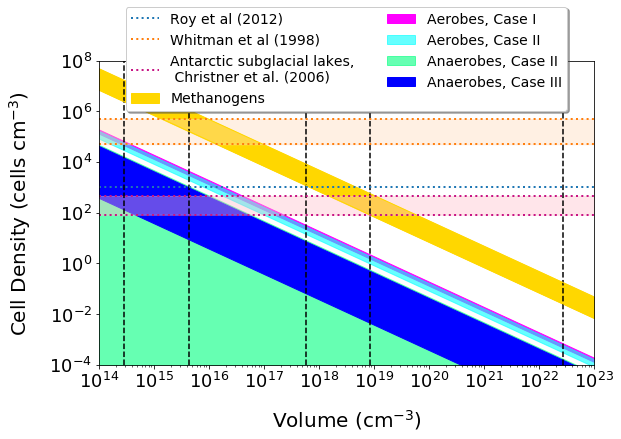

In [22]:
# y_low1 = np.zeros(1229 - 230)
# y_high1 = np.zeros(1229 - 230)
# y_low1[:] = 1e-10
# y_high1[:] = 1e11
# y_low2 = np.zeros(1817 - 818)
# y_high2 = np.zeros(1817 - 818)
# y_low2[:] = 1e-10
# y_high2[:] = 1e11
# y_low3 = np.zeros(1229 - 818)
# y_high3 = np.zeros(1229 - 818)
# y_low3[:] = 1e-10
# y_high3[:] = 1e11

fig1 = plt.figure(1)
fig1.set_figheight(6.5)
fig1.set_figwidth(11)
plt.clf()


plt.axvline(x = V_TS[0], color = 'k', linestyle = '--') 
#plt.text(1.7e16, 1e3, 'SPT, depth = 1m', fontsize=17, rotation=90, fontweight = 'semibold')
plt.axvline(x = V_TS[1], color = 'k', linestyle = '--') 
#plt.text(1.7e18,2e3, 'SPT, depth = 100m', fontsize=17, rotation=90, fontweight = 'semibold')
plt.axvline(x = V_floor[0], color = 'k', linestyle = '--') 
#plt.text(2.6e17,5e3, 'Seafloor, depth = 1m', fontsize=17, rotation=90, fontweight = 'semibold') 
plt.axvline(x = V_floor[1], color = 'k', linestyle = '--') 
#plt.text(2.6e19,2e4, 'Seafloor, depth = 100m', fontsize=17, rotation=90, fontweight = 'semibold') 
plt.axvline(x = V_ocean, color = 'k', linestyle = '--') 
#plt.text(1.65e22,3e2, 'Ocean Volume', fontsize=17, rotation=90, fontweight = 'semibold')
plt.loglog(V, max_dense_meth, 'gold', linewidth = 1)
plt.loglog(V, min_dense_meth, 'gold', linewidth = 1)
plt.fill_between(V, min_dense_meth, max_dense_meth, color = 'gold', label = 'Methanogens')
plt.fill_between(V, min_dense_I, max_dense_I, color = 'fuchsia', alpha = 1.0, label = 'Aerobes, Case I')
plt.fill_between(V, min_dense_aeII, max_dense_aeII, color = 'aqua', alpha = 0.6, label = 'Aerobes, Case II')
plt.fill_between(V, min_dense_anII, max_dense_anII, color = 'springgreen', alpha = 0.6, label = 'Anaerobes, Case II')
plt.fill_between(V, min_dense_III, max_dense_III, color = 'blue', label = 'Anaerobes, Case III')
#plt.fill_between(V, min_dense_anII, max_dense_anII, fill = False, hatch='\\')

plt.plot([1e14, 1e23], [1e3,1e3], linestyle = ':', linewidth = 2, label = 'Roy et al (2012)')
plt.plot([1e14, 1e23], [5e4,5e4], linestyle = ':', linewidth = 2, color = '#ff7f0e', label = 'Whitman et al (1998)')
plt.plot([1e14, 1e23], [5e5,5e5], linestyle = ':', linewidth = 2, color = '#ff7f0e')
plt.fill_between(V,5e4, 5e5, color = 'peachpuff', alpha = 0.4)
plt.plot([1e14, 1e23], [83,83], linestyle = ':', linewidth = 2, color = 'mediumvioletred', label = 'Antarctic subglacial lakes, \n Christner et al. (2006)')
plt.plot([1e14, 1e23], [460,460], linestyle = ':', linewidth = 2, color = 'mediumvioletred')
plt.fill_between(V,83, 460, color = 'pink', alpha = 0.4)

plt.xlabel('Volume (cm$^{-3}$)')
plt.ylabel('Cell Density (cells cm$^{-3}$)')
#plt.yscale('log')
plt.xlim(1e14,1e23)
plt.ylim(1e-4,1e8)
#plt.title(r"Total O$_{2}$ Concentration in the Ocean")
#plt.legend(bbox_to_anchor=(1,1), prop={'size': 16})
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2),  prop={'size': 14},
          ncol=2, fancybox=True, shadow=True)
#plt.title('Theoretical Cell Densities in the Enceladus seafloor')
plt.subplots_adjust(left=0.125, right=0.75, top=0.8, bottom=0.15)
#plt.grid()
#plt.savefig('./Young Enceladus/CellAbundances_YoungEnceladus.png', bbox_inches = 'tight')
plt.savefig('CellAbundances.png', dpi=200, bbox_inches = 'tight')
#plt.show()

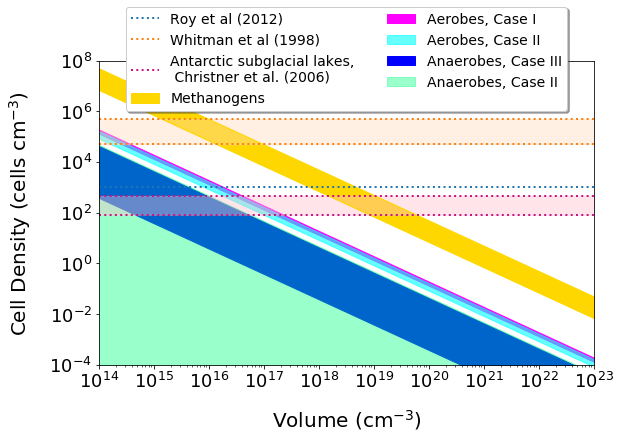

In [29]:
##PUBLIC FRIENDLY VERSION

# y_low1 = np.zeros(1229 - 230)
# y_high1 = np.zeros(1229 - 230)
# y_low1[:] = 1e-10
# y_high1[:] = 1e11
# y_low2 = np.zeros(1817 - 818)
# y_high2 = np.zeros(1817 - 818)
# y_low2[:] = 1e-10
# y_high2[:] = 1e11
# y_low3 = np.zeros(1229 - 818)
# y_high3 = np.zeros(1229 - 818)
# y_low3[:] = 1e-10
# y_high3[:] = 1e11

fig1 = plt.figure(1)
fig1.set_figheight(6.5)
fig1.set_figwidth(11)
plt.clf()


#plt.axvline(x = V_TS[0], color = 'k', linestyle = '--') 
#plt.text(1.7e16, 1e3, 'SPT, depth = 1m', fontsize=17, rotation=90, fontweight = 'semibold')
#plt.axvline(x = V_TS[1], color = 'k', linestyle = '--') 
#plt.text(1.7e18,2e3, 'SPT, depth = 100m', fontsize=17, rotation=90, fontweight = 'semibold')
#plt.axvline(x = V_floor[0], color = 'k', linestyle = '--') 
#plt.text(2.6e17,5e3, 'Seafloor, depth = 1m', fontsize=17, rotation=90, fontweight = 'semibold') 
#plt.axvline(x = V_floor[1], color = 'k', linestyle = '--') 
#plt.text(2.6e19,2e4, 'Seafloor, depth = 100m', fontsize=17, rotation=90, fontweight = 'semibold') 
#plt.axvline(x = V_ocean, color = 'k', linestyle = '--') 
#plt.text(1.65e22,3e2, 'Ocean Volume', fontsize=17, rotation=90, fontweight = 'semibold')
plt.loglog(V, max_dense_meth, 'gold', linewidth = 1)
plt.loglog(V, min_dense_meth, 'gold', linewidth = 1)
plt.fill_between(V, min_dense_meth, max_dense_meth, color = 'gold', label = 'Methanogens')
plt.fill_between(V, min_dense_I, max_dense_I, color = 'fuchsia', alpha = 1.0, label = 'Aerobes, Case I')
plt.fill_between(V, min_dense_aeII, max_dense_aeII, color = 'aqua', alpha = 0.6, label = 'Aerobes, Case II')
plt.fill_between(V, min_dense_III, max_dense_III, color = 'blue', label = 'Anaerobes, Case III')
plt.fill_between(V, min_dense_anII, max_dense_anII, color = 'springgreen', alpha = 0.4, label = 'Anaerobes, Case II')
#plt.fill_between(V, min_dense_anII, max_dense_anII, fill = False, hatch='\\')

plt.plot([1e14, 1e23], [1e3,1e3], linestyle = ':', linewidth = 2, label = 'Roy et al (2012)')
plt.plot([1e14, 1e23], [5e4,5e4], linestyle = ':', linewidth = 2, color = '#ff7f0e', label = 'Whitman et al (1998)')
plt.plot([1e14, 1e23], [5e5,5e5], linestyle = ':', linewidth = 2, color = '#ff7f0e')
plt.fill_between(V,5e4, 5e5, color = 'peachpuff', alpha = 0.4)
plt.plot([1e14, 1e23], [83,83], linestyle = ':', linewidth = 2, color = 'mediumvioletred', label = 'Antarctic subglacial lakes, \n Christner et al. (2006)')
plt.plot([1e14, 1e23], [460,460], linestyle = ':', linewidth = 2, color = 'mediumvioletred')
plt.fill_between(V,83, 460, color = 'pink', alpha = 0.4)

plt.xlabel('Volume (cm$^{-3}$)')
plt.ylabel('Cell Density (cells cm$^{-3}$)')
#plt.yscale('log')
plt.xlim(1e14,1e23)
plt.ylim(1e-4,1e8)
#plt.title(r"Total O$_{2}$ Concentration in the Ocean")
#plt.legend(bbox_to_anchor=(1,1), prop={'size': 16})
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2),  prop={'size': 14},
          ncol=2, fancybox=True, shadow=True)
#plt.title('Theoretical Cell Densities in the Enceladus seafloor')
plt.subplots_adjust(left=0.125, right=0.75, top=0.8, bottom=0.15)
#plt.grid()
#plt.savefig('./Young Enceladus/CellAbundances_YoungEnceladus.png', bbox_inches = 'tight')
plt.savefig('CellAbundances_PublicFriendly.png', dpi=200, bbox_inches = 'tight')
#plt.show()

In [ ]:
np.where(V>8.5e18)
V[1096]

In [ ]:
print(max_dense_meth[1096])
print(min_dense_I[1096])
print(min_dense_aeII[1096])
print(max_dense_anII[1096])
print(max_dense_III[1096])


In [25]:
'%E' %V_floor[1]

'8.600751E+18'